# Lab 7: Llama Stack

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [7]:
import sys
!{sys.executable} -m pip install llama-stack==0.0.36
!{sys.executable} -m pip install llama-stack-client==0.0.35

  Using cached llama_stack-0.0.36-py3-none-any.whl.metadata (5.2 kB)
  Using cached fire-0.7.0.tar.gz (87 kB)
  Preparing metadata (setup.py) ... done
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
Using cached llama_stack-0.0.36-py3-none-any.whl (223 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.9 MB/s eta 0:00:00a 0:00:01
Using cached termcolor-2.5.0-py3-none-any.whl (7.8 kB)
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=ed47750aefb96b031931f4c1e1556d0b835e59ef3ab71a939fa8ff3d26d1cd08
  Stored in directory: /Users/ytchen/Library/Caches/pip/wheels/9e/5b/45/29f72e55d87a29426b04b3cfdf20325c079eb97ab74f59017d
Successfully built fire
  Using cached llama_stack_client-0.0.35-py3-none-any.whl.metadata (13 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
Using cached llama_stack_client-0.0.35-py3-none-any.whl (184 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
import os
_ = load_dotenv() #loads 'TOGETHER_API_KEY'

In [3]:
#!pip install llama-stack==0.0.36 llama-stack-client==0.0.35

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>utils.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

In [4]:
!llama stack build --list-templates

+-----------------------------+-------------------------------------+----------------------------------------------------------------------------------+
| Template Name               | Providers                           | Description                                                                      |
+-----------------------------+-------------------------------------+----------------------------------------------------------------------------------+
| local-together              | {                                   | Use Together.ai for running LLM inference                                        |
|                             |   "inference": "remote::together",  |                                                                                  |
|                             |   "memory": "meta-reference",       |                                                                                  |
|                             |   "safety": "remote::together",     |             

In [5]:
!llama stack list-apis

+--------------+
| API          |
+--------------+
| inference    |
+--------------+
| safety       |
+--------------+
| agents       |
+--------------+
| memory       |
+--------------+
| telemetry    |
+--------------+
| models       |
+--------------+
| shields      |
+--------------+
| memory_banks |
+--------------+


#  Llama Stack Inference

In [8]:
LLAMA_STACK_API_TOGETHER_URL="https://llama-stack.together.ai"
LLAMA31_8B_INSTRUCT = "Llama3.1-8B-Instruct"

from llama_stack_client import LlamaStackClient
from llama_stack_client.lib.inference.event_logger import EventLogger
from llama_stack_client.types import UserMessage

async def run_main():
    client = LlamaStackClient(
        base_url=LLAMA_STACK_API_TOGETHER_URL,
    )

    iterator = client.inference.chat_completion(
        messages=[
            UserMessage(
                content="Who wrote the book Innovator's Dilemma? How about Charlotte's Web?",
                role="user",
            ),

            UserMessage(
                content="which book was published first?",
                role="user",
            ),
        ],
        model=LLAMA31_8B_INSTRUCT,
        stream=True
    )

    async for log in EventLogger().log(iterator):
        log.print()
        #print("?")

await run_main()

Assistant> The book "The Innovator's Dilemma" was written by Clayton Christensen. It was published in 1997.

"Charlotte's Web" is a children's novel written by E.B. White. It was published in 1952.

Therefore, "Charlotte's Web" was published first, 45 years before "The Innovator's Dilemma".


# Llama Stack Agent

In [9]:
import asyncio
from typing import List, Optional, Dict

from llama_stack_client import LlamaStackClient
from llama_stack_client.lib.agents.event_logger import EventLogger

from llama_stack_client.types import SamplingParams, UserMessage
from llama_stack_client.types.agent_create_params import AgentConfig

In [10]:

class Agent:
    def __init__(self):
        self.client = LlamaStackClient(
            base_url=LLAMA_STACK_API_TOGETHER_URL,
        )

    def create_agent(self, agent_config: AgentConfig):
        agent = self.client.agents.create(
            agent_config=agent_config,
        )
        self.agent_id = agent.agent_id
        session = self.client.agents.sessions.create(
            agent_id=agent.agent_id,
            session_name="example_session",
        )
        self.session_id = session.session_id

    async def execute_turn(self, content: str):
        response = self.client.agents.turns.create(
            agent_id=self.agent_id,
            session_id=self.session_id,
            messages=[
                UserMessage(content=content, role="user"),
            ],
            stream=True,
        )

        for chunk in response:
            if chunk.event.payload.event_type != "turn_complete":
                yield chunk



In [11]:
async def run_main():
    agent_config = AgentConfig(
        model=LLAMA31_8B_INSTRUCT,
        instructions="You are a helpful assistant",
        enable_session_persistence=False,
    )

    agent = Agent()
    agent.create_agent(agent_config)

    prompts = [
        "Who wrote the book Charlotte's Web?",
        "Three best quotes?",
    ]

    for prompt in prompts:
        print(f"User> {prompt}")
        response = agent.execute_turn(content=prompt)
        async for log in EventLogger().log(response):
            if log is not None:
                log.print()

await run_main()

User> Who wrote the book Charlotte's Web?
inference> The book "Charlotte's Web" was written by E.B. White. It was first published in 1952. E.B. White is an American author, best known for this beloved children's novel about friendship between a pig named Wilbur and a spider named Charlotte.
User> Three best quotes?
inference> Here are three notable quotes from "Charlotte's Web":

1. "Wherever you live is holy land." - Charlotte's words remind Wilbur of the importance of appreciating his surroundings, regardless of where he is.

2. "It is not often that someone comes along who is a true friend and a good writer. Charlotte was both." - E.B. White's quote about Charlotte's character says it all.

3. "What a wonderful world it would be if it were made of sweet cream and rainbows." - This quote from Charlotte showcases her kindness and vivid imagination, embodying the themes of hope and friendship in the novel.


# Llama Stack with Llama 3.2 vision model

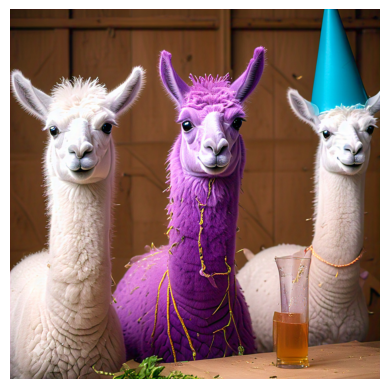

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(path):
  img = Image.open(path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

display_image("./content/Llama_Repo.jpeg")

In [13]:
import base64

from llama_stack_client import LlamaStackClient
from llama_stack_client.types import agent_create_params

LLAMA32_11B_INSTRUCT = "Llama3.2-11B-Vision-Instruct"

def encode_image(image_path):
  with open(image_path, "rb") as img:
    return base64.b64encode(img.read()).decode('utf-8')


In [14]:
class Agent:
    def __init__(self):
        self.client = LlamaStackClient(
            base_url=LLAMA_STACK_API_TOGETHER_URL,
        )

    def create_agent(self, agent_config: AgentConfig):
        agent = self.client.agents.create(
            agent_config=agent_config,
        )
        self.agent_id = agent.agent_id
        session = self.client.agents.sessions.create(
            agent_id=agent.agent_id,
            session_name="example_session",
        )
        self.session_id = session.session_id

    async def execute_turn(self, prompt: str, image_path: str):
        base64_image = encode_image(image_path)

        messages = [{
            "role": "user",
            "content": [
              {
                "image": {
                  "uri": f"data:image/jpeg;base64,{base64_image}"
                }
              },
              prompt,
            ]
        }]

        response = self.client.agents.turns.create(
            agent_id=self.agent_id,
            session_id=self.session_id,
            messages = messages,
            stream=True,
        )

        for chunk in response:
            if chunk.event.payload.event_type != "turn_complete":
                yield chunk

In [15]:
async def run_main(image_path, prompt):
    agent_config = AgentConfig(
        model=LLAMA32_11B_INSTRUCT,
        instructions="You are a helpful assistant",
        enable_session_persistence=False,
    )

    agent = Agent()
    agent.create_agent(agent_config)

    print(f"User> {prompt}")
    response = agent.execute_turn(prompt=prompt, image_path=image_path)
    async for log in EventLogger().log(response):
        if log is not None:
            log.print()



In [16]:
await run_main("./content/Llama_Repo.jpeg",
         "How many different colors are those llamas?\
         What are those colors?")

User> How many different colors are those llamas?         What are those colors?
inference> There are three colors of llama depicted in the image: white, purple, and blue. The white color is present on the two llamas on the left side of the image, while the purple color is visible on the middle llama. The blue color is evident on the party hat worn by the llama on the right side of the image.
